
Model of "Albireo: Energy-Efficient Acceleration of Convolutional Neural
Networks via Silicon Photonics", ISCA 2021
--------------------------------------------------------------------------------

Paper by Kyle Shiflett, Avinash Karanth, Razvan Bunescu, and Ahmed Louri

## Description

Albireo is a silicon photonic accelerator to accelerate convolutional neural
networks. As a photonic accelerator, Albireo leverages the analog-optical (AO)
domain in addition to the analog-electrical (AE) and digital-electrical (DE)
domains. The analog-optical domain has the advantage of low-energy data movement
with photonic interconnects. Additionally, optical components can leverage
wavelength division multiplexing (WDM), where multiple wavelengths of light can
be transferred and/or processed at the same time by the same component.

Some of the important variables for albireo_isca_2021:

- *ARRAY_WORDLINES*: 9 rows in the array
- *ARRAY_BITLINES*: 5 columns in the array
- *ARRAY_PARALLEL_INPUTS*: 45 input slice(s) consumed in each cycle.
- *ARRAY_PARALLEL_WEIGHTS*: 9 weights slice(s) used for computation in each cycle.
- *ARRAY_PARALLEL_OUTPUTS*: 5 output(s) produced in each cycle.
- *TECHNOLOGY*: 7 nm
- *ADC_RESOLUTION*: 8 bit(s)
- *DAC_RESOLUTION*: 8 bit(s)
- *N_ADC_PER_BANK*: 5 ADC(s)
- *SUPPORTED_INPUT_BITS*: 8 bit(s)
- *SUPPORTED_OUTPUT_BITS*: 8 bit(s)
- *SUPPORTED_WEIGHT_BITS*: 8 bit(s)
- *BITS_PER_CELL*: 8 bit(s)
- *CIM_UNIT_WIDTH_CELLS*: 1 adjacent cell(s) in a wordline store bit(s) in one weight slice and process one input & output slice together
- *CIM_UNIT_DEPTH_CELLS*: 1 adjacent cell(s) in a bitline operate in separate cycles
- *CELL_CONFIG*: None 
- *GLOBAL_CYCLE_SECONDS*: 1.25e-10 clock period

### Macro Level

Albireo's "macro" is a full accelerator chip. At the chip level, the accelerator
includes a global buffer to store inputs and outputs. An off-chip laser supplies
63 wavelengths of light to the accelerator. 

- *Input Path*: Digital-electrical inputs are fetched from the global buffer. A
  DAC converts them to analog-electrical before a mach-zender-modulator (MZM)
  and microring resonators (MRRs) convert them to optical signals. The
  analog-optical signals are then passed to an analog-optical multicast network.
  63 independent wavelengths transmit independent inputs, so parallel 63
  analog-optical inputs can be sent to the next level at once.
- *Weight Path*: Generally, the Albireo paper assumes that weights are
  pre-loaded at levels below this one, so no weight path is shown in the image.
  If we were to load weights (*e.g.*, by placing a DRAM above the accelerator in
  the hierarchy in our model), then weights would be loaded in.
- *Output Path*: Outputs are stored in the global buffer. A digital-electrical
  network transfers outputs from the buffer to lower-level tiles.

Next, there are 9 photonic locally connected groups (PLCGs) in the macro. Inputs
are reused spatially between PLCGs (*i.e.,* each analog-optical interconnect
connects to all PLCGs). Outputs and weights are not reused because each PLCG
uses different weights and generates different outputs.

### Photonic Locally Connected Group (PLCG) Level

The PLCG receives analog-optical inputs, stores digital-electrical weights, and
produces digital-electrical outputs. It includes three Photonic Locally
Connected Unit (PLCU) containers that work together to compute outputs.

- *Input Path*: Analog-optical inputs pass directly to the PLCUs in the PLCG.
- *Weight Path*: A weight cache is used to store weights. It sends
  digital-electrical weights to the PLCUs in the PLCG.
- *Output Path*: The PLCUs generate analog-electrical outputs, which are summed
  on an analog-electrical multicast network. After summation, analog-electrical
  outputs sent to a trans-impedance amplifier (TIA) and ADC to be converted to
  digital-electrical. An output register holds in-progress digital-electrical
  outputs after they are converted by the ADC.
  
Next, there are 3 photonic locally connected units (PLCUs) in each PLCG. Outputs
are reused between PLCUs (*i.e.*, analog-electrical outputs are summed together
between PLCUs in the PLCG). Inputs and weights are not reused between PLCUs.

### Photonic Locally Connected Unit (PLCU) Level

Each PLCU includes an array of optical components that computes MAC operations.
The array is subdivided vertically into three star coupled groups of rows. From
the upper level, a PLCU has three analog-optical input ports that receive 7
analog-optical inputs each (as different wavelengths). Each of these ports is
connected to a different star coupled group of rows.

- *Input Path*: Analog-optical inputs from the upper level are passed directly
  to star coupled groups of rows.
- *Weight Path*: Digital-electrical weights from the upper level are unicast to
  the star coupled groups of rows.
- *Output Path*: Star coupled groups of rows produce analog-optical outputs that
  are summed on an optical multicast network. The analog-optical outputs are
  converted to analog-electrical outputs by photodiodes before being passed up
  to the upper level.

Next, there are three star coupled groups of rows in each PLCU. Outputs are
reused between star coupled groups of rows (*i.e.*, analog-optical outputs are
summed on optical interconnects), while inputs and weights are not reused
(*i.e.*, each star coupled group of rows uses a different set of inputs and
weights). 

### Star Coupled Group of Rows Level

A star coupled group of rows is a group of three rows in the array.

- *Input Path*: Arrayed waveguide grating (AWG) picks up 7 of the 63 inputs from
  the global 63-parallel-input optical interconnect. These 7 inputs, as parallel
  wavelengths, are sent to a star coupler, which copies the inputs three times.
  One copy of each input is sent to each row in the star coupled group of rows
  (*i.e.*, each row receives all 7 optical-analog inputs). *Note*: The Albireo
  paper shows the AWGs at the PLCG level, but their area calculation suggests
  that every star coupled group of rows has its own AWG, so we model it here.
- *Weight Path*: Each row receives a different electrical-digital weight.
- *Output Path*: The analog-optical outputs from each row are summed on an
  optical multicast network.
  
Next, there are three rows in each star coupled group of rows. Outputs are
reused between rows (*i.e.*, analog-optical outputs are summed on optical
interconnects), while inputs and weights are not reused.

While technically, all rows in a star coupled group of rows are using the same
set of seven inputs, Albireo clever trick to get extra reuse from convolutional
sliding windows. Consider the loop nest below, where we compute 5 outputs (P
dimension) using 3 weights (R dimension) and 7 inputs (Q dimension):

``` 

for R in [0..3):
  for P in [0..5):
    Outputs[P] += Inputs[P + R] * Weights[R]
```

In Albireo, each row computes one iteration of the outer R loop. This means
that, while all rows in a star coupled group of rows receive the same 7 inputs,
each one actually only uses 5 of them. Each row computes the same 5 outputs, and
these are summed together spatially between the rows to complete the loop nest.
Finally, note that each row in a star coupled group of rows uses a different
weight.

To implement this in Timeloop, we use a `star_coupler` component with coalescing
enabled. Each row reads 5 inputs from the `star_coupler`, and the `star_coupler`
coalesces these overlapping reads into a 7-input read.

### Row Level 
 
A single row computes a single iteration of the outer R loop from the loop nest
above. The row is subdivided into 5 columns.

- *Input Path*: A row uses 5 optical-analog inputs. The inputs pass through a
  mach-zender-modulator (MZM) and are modulated by the weight to produce a
  double-modulated (*i.e.*, input multiplied by weight) signal. Note that the
  inputs arrive as separate wavelengths on the same interconnect, so they can be
  modulated simultaneously by the same weight using one MZM.
- *Weight Path*: A row uses a single digital-electrical weight. The weight is
  passed through a DAC to produce an analog-electrical signal, then used in a
  MZM to modulate (*i.e.*, multiply it with) the inputs.
- *Output Path*: Each column in the row produces a different optical-analog
  output.
  
In a row, 5 columns all reuse the same weight. Each column uses a different
input and produces a different output. Note a few technical details:

- While multiple columns are connected by the same interconnect, and therefore
  they may technically see the same input, only one column may use a given
  input. This is because each input is encoded on a single wavelength, and the
  micro-ring resonator (MRR) in the column either consume the wavelength or not.
  For this reason, we enforce that inputs may not be reused between columns in a
  row.
- On the other hand, one weight modules *all* wavelengths that are provided to
  the row. For this reason, the weight can (must be) be reused between columns
  in a row.
- While the model shows inputs and weights traveling separately to each column,
  in the real architecture each input-weight combination would be combined into
  a single double-modulated optical-analog signal below the MZM. We set up the
  model such that all access counts and reuse patterns are correct despite this
  simplification.

### Column Level

Finally, each column in the row will compute a single iteration of the inner P
loop from the loop nest above. A MRR is used to select correct double-modulated
input-times-weight wavelength for the column.

- *Input and Weight Paths*: A MRR selects the correct input-and-weight-modulated
  wavelength for the column.
- *Output Path*: Computed outputs are passed directly up to the row.
  
We also include a laser at this level. While the laser is off-chip and not
physically present in a column, we model it here because we want the laser to be
powerful enough to supply all the light needed for all computations in the
accelerator. We charge energy down here so that the laser energy consumption is
proportional to the number of computations performed. With this setup, we can
change the number of PLCUs, PLCGs, rows, and columns and be sure that our
laser's energy consumption will scale accordingly.

Below this level, we represent an 8b input x 8b weight -> 8b output MAC as
8x8x8=512 virtualized 1bx1bx1b MAC units.


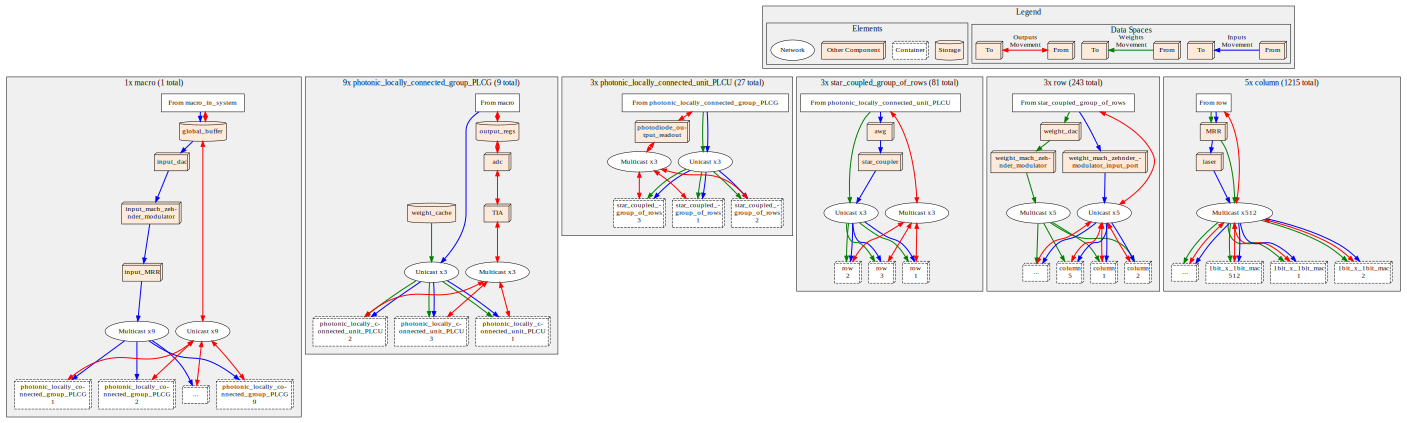

In [1]:
from _tests import scripts
from scripts.notebook_utils import *

display_markdown(
    f"""
Model of "Albireo: Energy-Efficient Acceleration of Convolutional Neural
Networks via Silicon Photonics", ISCA 2021
--------------------------------------------------------------------------------

Paper by Kyle Shiflett, Avinash Karanth, Razvan Bunescu, and Ahmed Louri

## Description

Albireo is a silicon photonic accelerator to accelerate convolutional neural
networks. As a photonic accelerator, Albireo leverages the analog-optical (AO)
domain in addition to the analog-electrical (AE) and digital-electrical (DE)
domains. The analog-optical domain has the advantage of low-energy data movement
with photonic interconnects. Additionally, optical components can leverage
wavelength division multiplexing (WDM), where multiple wavelengths of light can
be transferred and/or processed at the same time by the same component.

{get_important_variables_markdown('albireo_isca_2021')}

### Macro Level

Albireo's "macro" is a full accelerator chip. At the chip level, the accelerator
includes a global buffer to store inputs and outputs. An off-chip laser supplies
63 wavelengths of light to the accelerator. 

- *Input Path*: Digital-electrical inputs are fetched from the global buffer. A
  DAC converts them to analog-electrical before a mach-zender-modulator (MZM)
  and microring resonators (MRRs) convert them to optical signals. The
  analog-optical signals are then passed to an analog-optical multicast network.
  63 independent wavelengths transmit independent inputs, so parallel 63
  analog-optical inputs can be sent to the next level at once.
- *Weight Path*: Generally, the Albireo paper assumes that weights are
  pre-loaded at levels below this one, so no weight path is shown in the image.
  If we were to load weights (*e.g.*, by placing a DRAM above the accelerator in
  the hierarchy in our model), then weights would be loaded in.
- *Output Path*: Outputs are stored in the global buffer. A digital-electrical
  network transfers outputs from the buffer to lower-level tiles.

Next, there are 9 photonic locally connected groups (PLCGs) in the macro. Inputs
are reused spatially between PLCGs (*i.e.,* each analog-optical interconnect
connects to all PLCGs). Outputs and weights are not reused because each PLCG
uses different weights and generates different outputs.

### Photonic Locally Connected Group (PLCG) Level

The PLCG receives analog-optical inputs, stores digital-electrical weights, and
produces digital-electrical outputs. It includes three Photonic Locally
Connected Unit (PLCU) containers that work together to compute outputs.

- *Input Path*: Analog-optical inputs pass directly to the PLCUs in the PLCG.
- *Weight Path*: A weight cache is used to store weights. It sends
  digital-electrical weights to the PLCUs in the PLCG.
- *Output Path*: The PLCUs generate analog-electrical outputs, which are summed
  on an analog-electrical multicast network. After summation, analog-electrical
  outputs sent to a trans-impedance amplifier (TIA) and ADC to be converted to
  digital-electrical. An output register holds in-progress digital-electrical
  outputs after they are converted by the ADC.
  
Next, there are 3 photonic locally connected units (PLCUs) in each PLCG. Outputs
are reused between PLCUs (*i.e.*, analog-electrical outputs are summed together
between PLCUs in the PLCG). Inputs and weights are not reused between PLCUs.

### Photonic Locally Connected Unit (PLCU) Level

Each PLCU includes an array of optical components that computes MAC operations.
The array is subdivided vertically into three star coupled groups of rows. From
the upper level, a PLCU has three analog-optical input ports that receive 7
analog-optical inputs each (as different wavelengths). Each of these ports is
connected to a different star coupled group of rows.

- *Input Path*: Analog-optical inputs from the upper level are passed directly
  to star coupled groups of rows.
- *Weight Path*: Digital-electrical weights from the upper level are unicast to
  the star coupled groups of rows.
- *Output Path*: Star coupled groups of rows produce analog-optical outputs that
  are summed on an optical multicast network. The analog-optical outputs are
  converted to analog-electrical outputs by photodiodes before being passed up
  to the upper level.

Next, there are three star coupled groups of rows in each PLCU. Outputs are
reused between star coupled groups of rows (*i.e.*, analog-optical outputs are
summed on optical interconnects), while inputs and weights are not reused
(*i.e.*, each star coupled group of rows uses a different set of inputs and
weights). 

### Star Coupled Group of Rows Level

A star coupled group of rows is a group of three rows in the array.

- *Input Path*: Arrayed waveguide grating (AWG) picks up 7 of the 63 inputs from
  the global 63-parallel-input optical interconnect. These 7 inputs, as parallel
  wavelengths, are sent to a star coupler, which copies the inputs three times.
  One copy of each input is sent to each row in the star coupled group of rows
  (*i.e.*, each row receives all 7 optical-analog inputs). *Note*: The Albireo
  paper shows the AWGs at the PLCG level, but their area calculation suggests
  that every star coupled group of rows has its own AWG, so we model it here.
- *Weight Path*: Each row receives a different electrical-digital weight.
- *Output Path*: The analog-optical outputs from each row are summed on an
  optical multicast network.
  
Next, there are three rows in each star coupled group of rows. Outputs are
reused between rows (*i.e.*, analog-optical outputs are summed on optical
interconnects), while inputs and weights are not reused.

While technically, all rows in a star coupled group of rows are using the same
set of seven inputs, Albireo clever trick to get extra reuse from convolutional
sliding windows. Consider the loop nest below, where we compute 5 outputs (P
dimension) using 3 weights (R dimension) and 7 inputs (Q dimension):

``` 

for R in [0..3):
  for P in [0..5):
    Outputs[P] += Inputs[P + R] * Weights[R]
```

In Albireo, each row computes one iteration of the outer R loop. This means
that, while all rows in a star coupled group of rows receive the same 7 inputs,
each one actually only uses 5 of them. Each row computes the same 5 outputs, and
these are summed together spatially between the rows to complete the loop nest.
Finally, note that each row in a star coupled group of rows uses a different
weight.

To implement this in Timeloop, we use a `star_coupler` component with coalescing
enabled. Each row reads 5 inputs from the `star_coupler`, and the `star_coupler`
coalesces these overlapping reads into a 7-input read.

### Row Level 
 
A single row computes a single iteration of the outer R loop from the loop nest
above. The row is subdivided into 5 columns.

- *Input Path*: A row uses 5 optical-analog inputs. The inputs pass through a
  mach-zender-modulator (MZM) and are modulated by the weight to produce a
  double-modulated (*i.e.*, input multiplied by weight) signal. Note that the
  inputs arrive as separate wavelengths on the same interconnect, so they can be
  modulated simultaneously by the same weight using one MZM.
- *Weight Path*: A row uses a single digital-electrical weight. The weight is
  passed through a DAC to produce an analog-electrical signal, then used in a
  MZM to modulate (*i.e.*, multiply it with) the inputs.
- *Output Path*: Each column in the row produces a different optical-analog
  output.
  
In a row, 5 columns all reuse the same weight. Each column uses a different
input and produces a different output. Note a few technical details:

- While multiple columns are connected by the same interconnect, and therefore
  they may technically see the same input, only one column may use a given
  input. This is because each input is encoded on a single wavelength, and the
  micro-ring resonator (MRR) in the column either consume the wavelength or not.
  For this reason, we enforce that inputs may not be reused between columns in a
  row.
- On the other hand, one weight modules *all* wavelengths that are provided to
  the row. For this reason, the weight can (must be) be reused between columns
  in a row.
- While the model shows inputs and weights traveling separately to each column,
  in the real architecture each input-weight combination would be combined into
  a single double-modulated optical-analog signal below the MZM. We set up the
  model such that all access counts and reuse patterns are correct despite this
  simplification.

### Column Level

Finally, each column in the row will compute a single iteration of the inner P
loop from the loop nest above. A MRR is used to select correct double-modulated
input-times-weight wavelength for the column.

- *Input and Weight Paths*: A MRR selects the correct input-and-weight-modulated
  wavelength for the column.
- *Output Path*: Computed outputs are passed directly up to the row.
  
We also include a laser at this level. While the laser is off-chip and not
physically present in a column, we model it here because we want the laser to be
powerful enough to supply all the light needed for all computations in the
accelerator. We charge energy down here so that the laser energy consumption is
proportional to the number of computations performed. With this setup, we can
change the number of PLCUs, PLCGs, rows, and columns and be sure that our
laser's energy consumption will scale accordingly.

Below this level, we represent an 8b input x 8b weight -> 8b output MAC as
8x8x8=512 virtualized 1bx1bx1b MAC units.
"""
)
display_diagram(get_diagram("albireo_isca_2021", ignore=DIAGRAM_DEFAULT_IGNORE))


   This test replicates the results presented in Table III of the Albireo
   paper. We show the energy the MRR, MZM, Laser, TIA, DAC, ADC, and Cache.
   Results are shown assuming three levels of future technology scaling:
   conservative (high energy), moderate (medium energy), and aggressive (low
   energy).

   Albireo's energy primarily is consumed by DACs and MRRs. High MRR energy is
   because Albireo uses a large array of MRRs. High DAC energy is because
   Albireo requires many DAC converts for weights because analog-electrical
   weights are only reused for 5 MACs each (low MACs/convert, see the RAELLA
   paper Titanium law).
   

100%|██████████| 3/3 [00:14<00:00,  4.90s/it]


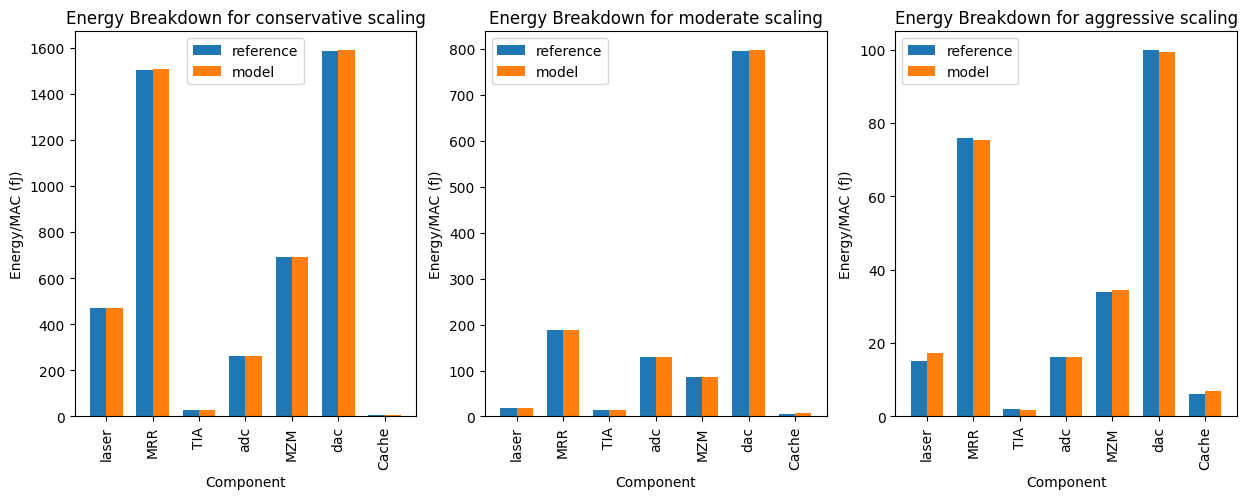

In [2]:
result = run_test("albireo_isca_2021", "test_energy_breakdown")
n_subplots = len(result)
fig, axs = plt.subplots(1, n_subplots, figsize=(5 * n_subplots, 5))
for i, r in enumerate(result):
    bar_side_by_side(
        r.get_compare_ref_energy(per_mac=True),
        xlabel="Component",
        ylabel="Energy/MAC (fJ)",
        title=f"Energy Breakdown for {r.variables['scaling']} scaling",
        ax=axs[i],
    )


   This test replicates the results presented in Fig 9 of the Albireo paper. We
   show the area the MRR, MZM, Laser, TIA, DAC, ADC, AWG, and Cache.

   Albireo's area is dominated by large optical-analog interconnects: AWGs and
   star couplers.
   

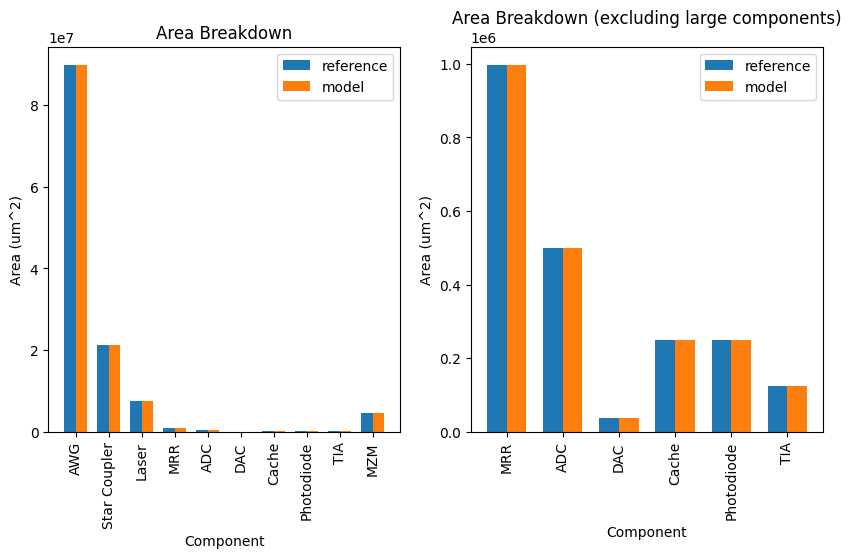

In [3]:
result = run_test("albireo_isca_2021", "test_area_breakdown")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
bar_side_by_side(
    result[0].get_compare_ref_area(),
    xlabel="Component",
    ylabel="Area (um^2)",
    title=f"Area Breakdown",
    ax=ax[0],
)
for big_component in ["AWG", "Star Coupler", "Laser", "MZM"]:
    del result[0].area[big_component]
bar_side_by_side
bar_side_by_side(
    result[0].get_compare_ref_area(),
    xlabel="Component",
    ylabel="Area (um^2)",
    title=f"Area Breakdown (excluding large components)",
    ax=ax[1],
)


   ### Full-DNN Energy Efficiency and Throughput

   This test explores the throughput and energy efficiency of the accelerator
   for different DNN layers and batch sizes. Looking at the results for the
   batch size of 1, we can see the following:

   - Albireo has low throughput for the fully-connected layers of all DNNs
     (last three layers of AlexNet, last two layers of VGG16, and last layer of
     ResNet18). This is because Albireo is optimized for convolutional layers
     and is underutilized when running fully-connected layers. This being said,
     if we look at the total latency and energy of each layer, we can see that
     fully-connected layers are not significant contributors to the overall
     energy and latency for VGG16 and ResNet18, so this underutilization has a
     smaller impact. However, for AlexNet, the fully-connected layers are
     significant contributors to the overall energy and latency, so this
     underutilization has a larger impact.
   - VGG16 has consistently high throughput for convolutional layers. This is
     because VGG16 uses large weight tensors and convolutional strides of one,
     which allows Albireo to achieve high utilization.
   - AlexNet and ResNet18 have lower throughput for convolutional layers. This
     is due to two factors. First, they often use convolutional strides larger
     than one, for which Albireo is not optimized and becomes underutilized.
     Second, their weight tensor sizes vary more than do those of VGG16, and
     small weight tensors sometimes results in underutilization. These effects
     can be seen especially in ResNet18 layers 7, 12, and 17, which have
     one-wide convolutional filters (R=S=1) that result in severe
     underutilization.

   We can also see that throughput and energy efficiency are correlated because
   underutilization both decreases throughput and increases energy. Energy
   efficiency generally varies less than does throughput because
   underutilization results in fewer activations of some componoents, which can
   somewhat offset the increased energy due to underutilization.

   The batch size of 8 shows similar trends, but the effect of underutilization
   is not as severe because we can increase utilization in some cases by
   running multiple inputs in parallel.

   We note that observing per-layer breakdowns in this way can be a valuable
   tool to understand what causes energy and/or throughput differences across
   full DNNs.
   

100%|██████████| 42/42 [00:42<00:00,  1.00s/it]


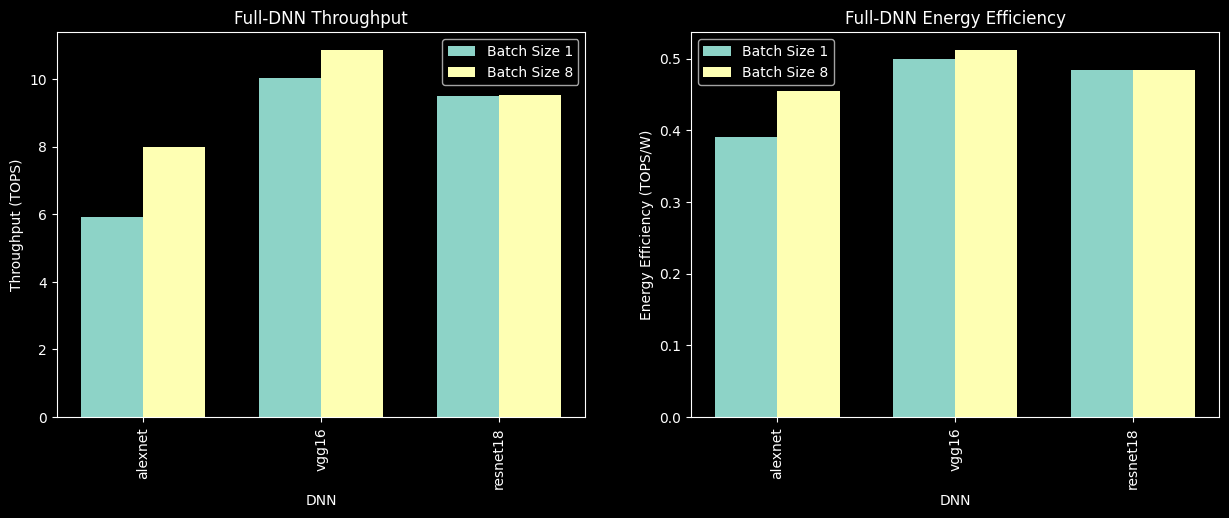

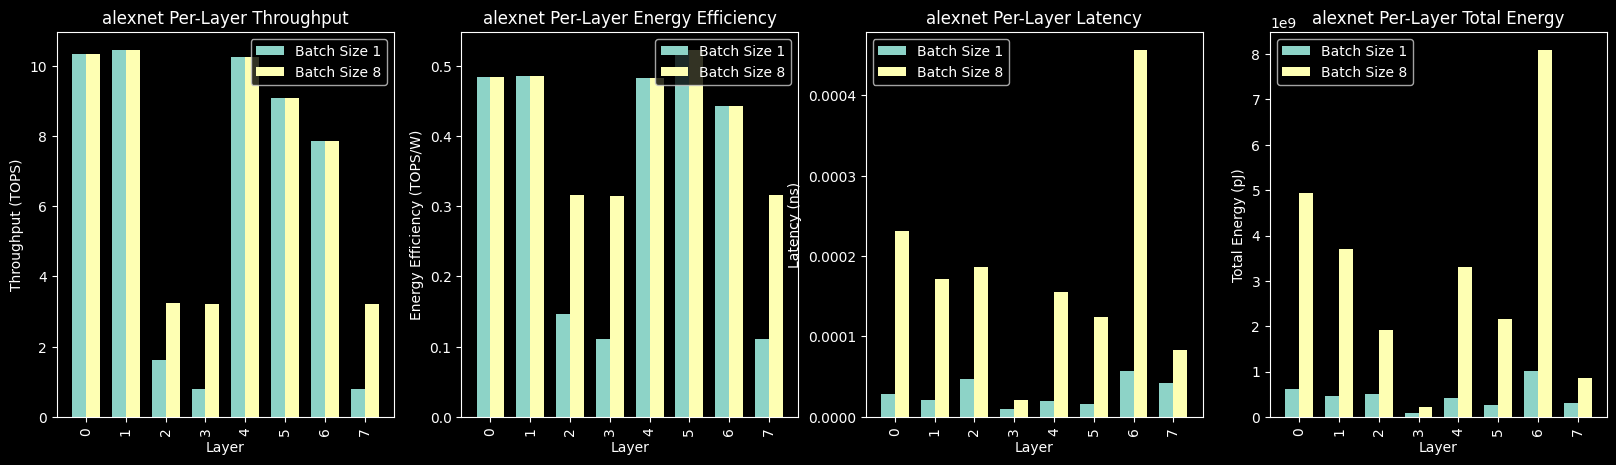

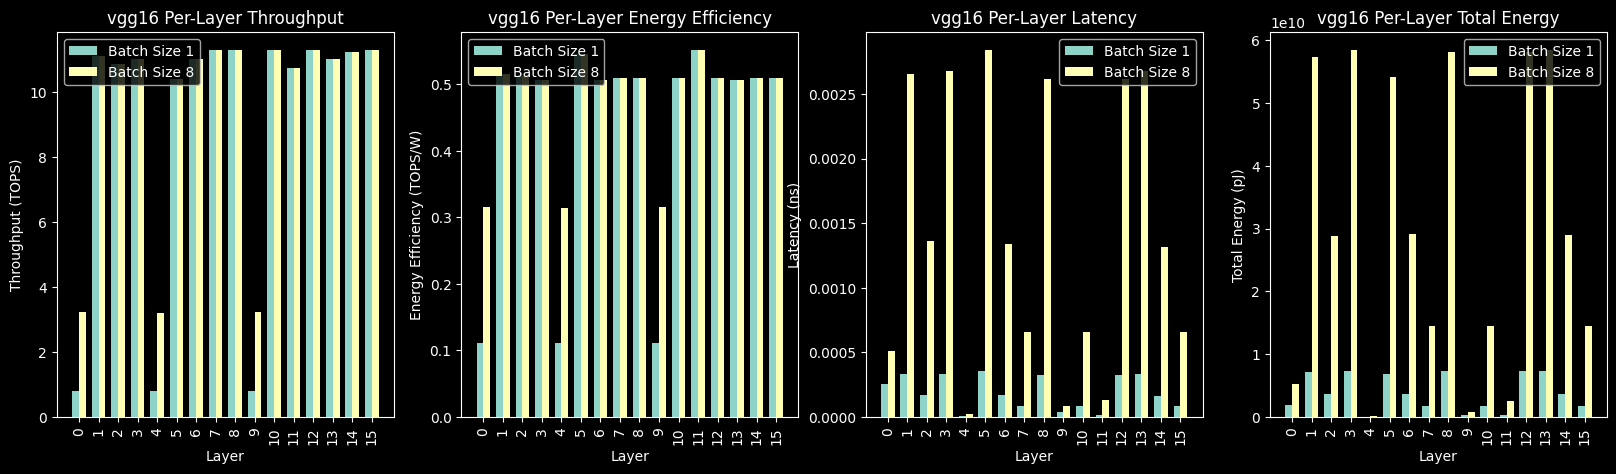

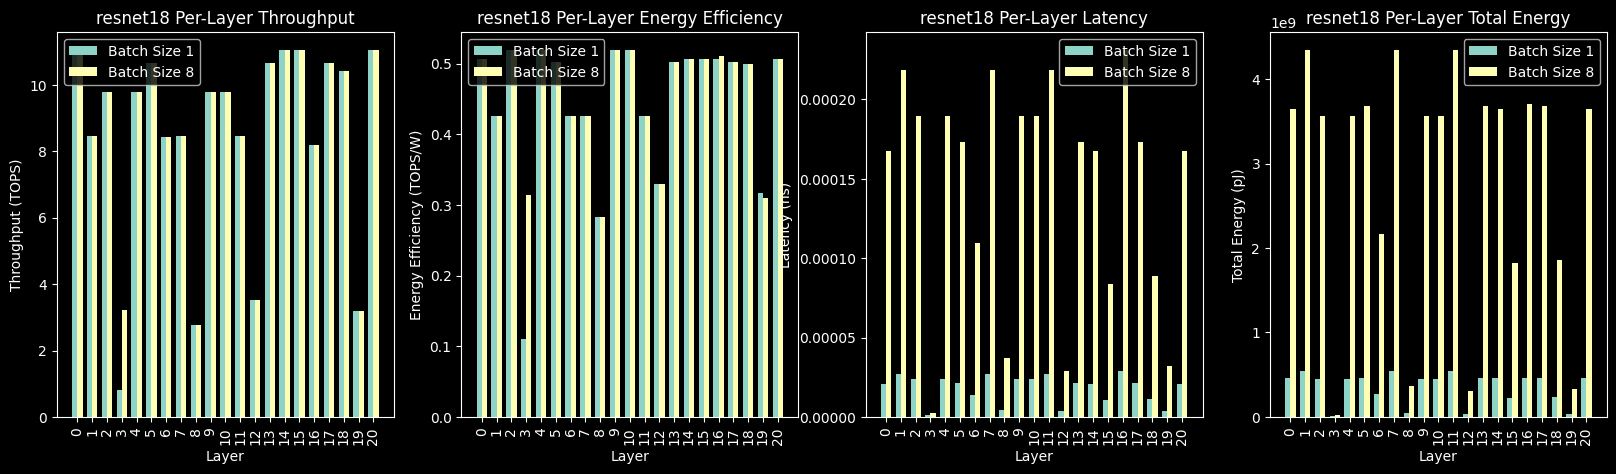

In [8]:
# This test may take a while to run. We have to find a mapping for every layer
# for every DNN being tested.
results = {}
for i, dnn in enumerate(["alexnet", "vgg16", "resnet18"]):
    results[dnn] = run_test(
        "albireo_isca_2021", "test_full_dnn", dnn_name=dnn, show_doc=i == 0
    )


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

tops, tops_per_w = {}, {}

# Full-DNN results
for dnn, r in results.items():
    tops[dnn], tops_per_w[dnn] = {}, {}
    for r2 in r.aggregate_by("BATCH_SIZE"):
        batch_size = f'Batch Size {r2.variables["BATCH_SIZE"]}'
        tops[dnn][batch_size] = r2.tops
        tops_per_w[dnn][batch_size] = r2.tops_per_w

for ax, data, title, ylabel in [
    (axs[0], tops, "Throughput", "TOPS"),
    (axs[1], tops_per_w, "Energy Efficiency", "TOPS/W"),
]:
    bar_side_by_side(
        data,
        xlabel="DNN",
        ylabel=f"{title} ({ylabel})",
        title=f"Full-DNN {title}",
        ax=ax,
    )

# Per-Layer Results
for dnn, result in results.items():
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    for ax, attrname, title, ylabel in [
        (ax[0], "tops", "Throughput", "TOPS"),
        (ax[1], "tops_per_w", "Energy Efficiency", "TOPS/W"),
        (ax[2], "latency", "Latency", "ns"),
        (ax[3], "total_energy", "Total Energy", "pJ"),
    ]:
        per_layer_results = {}
        for j, same_layers in enumerate(zip(*result.split_by("BATCH_SIZE"))):
            per_layer_results[j] = {
                f'Batch Size {r.variables["BATCH_SIZE"]}': getattr(r, attrname)
                for r in same_layers
            }
        bar_side_by_side(
            per_layer_results,
            xlabel="Layer",
            ylabel=f"{title} ({ylabel})",
            title=f"{dnn} Per-Layer {title}",
            ax=ax,
        )


   ### Architectural Exploration

   In this test, we explore how architecture-level decisions can affect the
   energy efficiency and throughput of the accelerator. One important concept
   to consider when designing mixed-signal accelerators is the amount of reuse
   that the accelerator leverages in the analog-optical, analog-electrical,
   digital-optical, digital-electrical domains. More reuse within a domain
   permits fewer crossings between domains, which can reduce the energy and
   area spent on data converters.

   In this test, we vary:

   - The number of PLCGs in the accelerator. Analog-optical inputs are reused
     between PLCGs, so increasing the number of PLCGs can decrease input
     conversion energy.
   - The number of PLCUs in the accelerator. Analog-electrical outputs are
     reused between PLCUs, so increasing the number of PLCUs can decrease
     output conversion energy.
   - The MRR toplogy. Albireo's MRR array can process up to 15 MACs using a
     convolutional sliding window with 7 inputs, 5 weights, and 5 outputs. This
     topology is often underutilized (because it is optimized only for
     convolutional layers with a stride of 1), so we try a different structure
     with 7 inputs, 3 weights, and 7 outputs. This new structure does not rely
     on convolutional sliding windows to be fully utilized, so it can achieve
     consistently-high utilization across many more layer shapes. It also has
     greater analog-optical weight reuse because every analog-optical weight is
     used for 7 MACs rather than 5, which permits fewer weight conversions (and
     therefore less weight conversion energy). As a tradeoff, the new structure
     has less analog-optical input and analog-optical output reuse, which can
     increase the number (and therefore energy) of input and output conversion.

   We find that increasing the number of PLCGs and PLCUs can increase energy
   efficiency through increased reuse. The new MRR topology decreases weight
   conversion energy and increases utilization, but increases input and output
   conversion energy. Overall, it increases energy efficiency.

   The new MRR topology has higher compute density due to the higher
   utilization. Larger architectures (more PLCUs and PLCGs) generally have
   lower compute density because some layers do not fully utilize them.
   

100%|██████████| 378/378 [05:22<00:00,  1.17it/s]


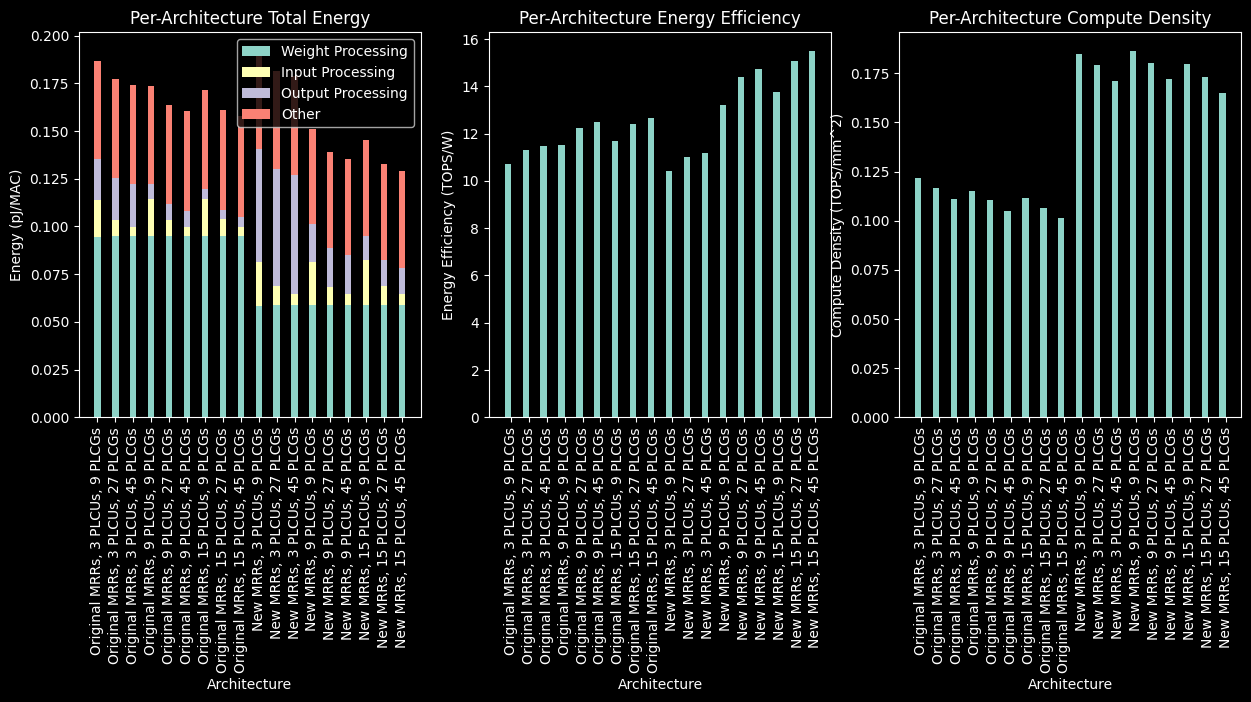

In [5]:
results = run_test(
    "albireo_isca_2021", "test_explore_architectures", dnn_name="resnet18"
)
organized = {}
for r in results:
    key = []
    if r.variables["N_COLUMNS"] == 5:
        key.append(f"Original MRRs")
    else:
        key.append(f"New MRRs")
    key.append(f'{r.variables["N_PLCU"]} PLCUs')
    key.append(f'{r.variables["N_PLCG"]} PLCGs')
    key = ", ".join(key)
    organized[key] = r

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

bar_stacked(
    {k: v.per_mac("energy") for k, v in organized.items()},
    xlabel="Architecture",
    ylabel="Energy (pJ/MAC)",
    title="Per-Architecture Total Energy",
    ax=axs[0],
)

for ax, attrname, title, ylabel in [
    (axs[1], "tops_per_w", "Energy Efficiency", "TOPS/W"),
    (axs[2], "tops_per_mm2", "Compute Density", "TOPS/mm^2"),
]:
    bar_side_by_side(
        {k: {"": getattr(v, attrname)} for k, v in organized.items()},
        xlabel="Architecture",
        ylabel=f"{title} ({ylabel})",
        title=f"Per-Architecture {title}",
        ax=ax,
    )

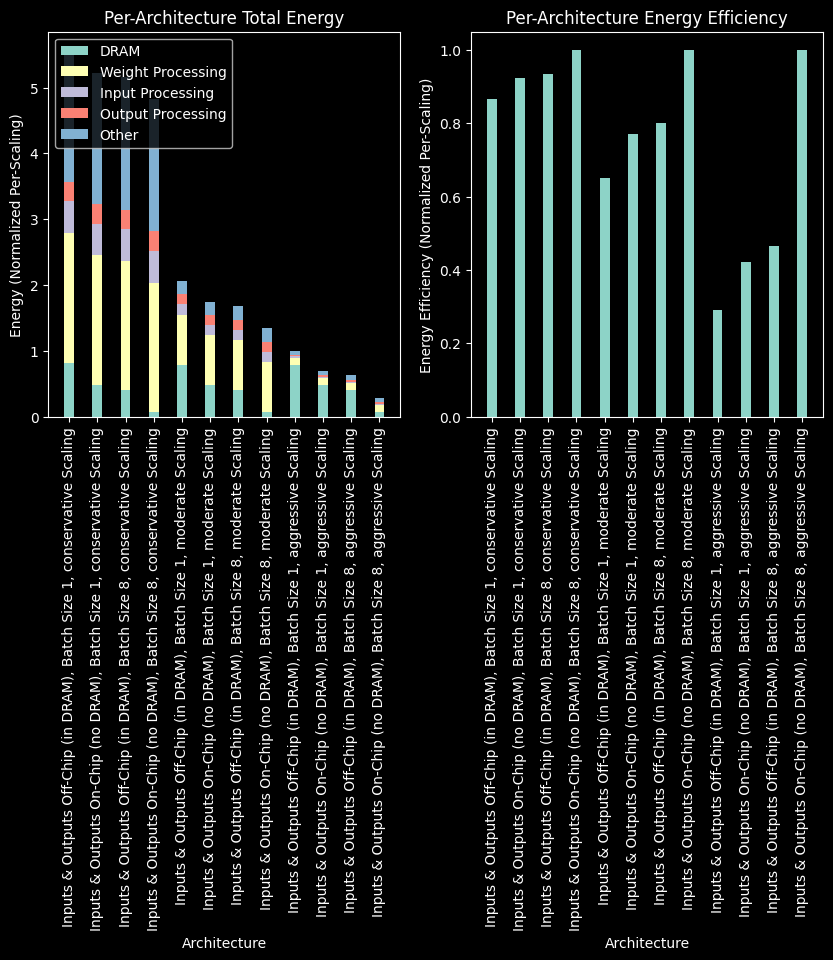

In [7]:
results = run_test("albireo_isca_2021", "test_explore_main_memory", dnn_name="resnet18")

organized = {}
for r in results:
    key = []
    if "fetch_all" in r.variables["SYSTEM_SETTING"]:
        key.append(f"Inputs & Outputs Off-Chip (in DRAM)")
    else:
        key.append(f"Inputs & Outputs On-Chip (no DRAM)")

    key.append(f'Batch Size {r.variables["BATCH_SIZE"]}')
    key.append(f'{r.variables["SCALING"]} Scaling')
    key = ", ".join(key)
    organized[key] = r

# Normalize for each scaling
for scaling in set(r.variables["SCALING"] for r in organized.values()):
    relevant = [r for r in organized.values() if r.variables["SCALING"] == scaling]
    max_total_energy = max(r.per_mac("total_energy") for r in relevant)
    max_efficiency = max(r.tops_per_w for r in relevant)
    for r in relevant:
        r.total_energy /= max_total_energy
        r.tops_per_w /= max_efficiency
        for k, v in r.energy.items():
            r.energy[k] /= max_total_energy


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

bar_stacked(
    {k: v.per_mac("energy") for k, v in organized.items()},
    xlabel="Architecture",
    ylabel="Energy (Normalized Per-Scaling)",
    title="Total Energy",
    ax=axs[0],
    legend_loc="upper left",
)
bar_stacked(
    {k: {"": v.tops_per_w} for k, v in organized.items()},
    xlabel="Architecture",
    ylabel="Energy Efficiency (Normalized Per-Scaling)",
    title="Energy Efficiency",
    ax=axs[1],
)